<a href="https://www.kaggle.com/code/mohamedchahed/pr-diction-de-la-d-sertion-bancaire?scriptVersionId=127964602" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction 

la désertion des clients est un problème majeur pour les entreprises de services financiers, y compris les banques. Lorsqu'un client quitte une banque, cela peut avoir un impact négatif sur les revenus de l'entreprise, ainsi que sur sa réputation. Par conséquent, prédire le churn des clients est essentiel pour les banques afin de maintenir leur rentabilité et leur croissance.

Cependant, prédire le churn des clients est une tâche difficile en raison de divers facteurs, tels que la complexité des comportements des clients et l'ensemble de données déséquilibré. Le déséquilibre de classe se produit lorsque le nombre de clients qui restent avec la banque est beaucoup plus élevé que le nombre de clients qui la quittent. Cela peut causer un biais dans la performance prédictive des modèles. Dans ce projet, nous allons explorer différentes techniques de rééchantillonnage pour résoudre ce problème de déséquilibre de classe et construire des modèles précis pour prédire le churn des clients bancaires.

# Importation des bibliothèques nécessaires

In [2]:
# Import necessary libraries 
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc


# Description de la base de données

Le dataset utilisé dans ce projet a été obtenu à partir du site https://leaps.analyttica.com/home. Il s'agit d'un ensemble de données sur les clients d'une banque, contenant des informations telles que l'âge, le salaire, l'état matrimonial, la limite de la carte de crédit, la catégorie de carte de crédit, etc. Il y a presque 18 fonctionnalités au total.

Le dataset comprend 10 000 clients, dont seulement 16,07% ont quitté la banque, ce qui rend la prédiction du churn des clients plus difficile en raison du déséquilibre de classe.

In [71]:
# Import data
df = pd.read_csv("/kaggle/input/credit-card-customers/BankChurners.csv", usecols=list(range(0,21)))
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


# Analyse exploratoire des données

Text(0.5, 0, "Variable d'interet 'Attrition_Flag ")

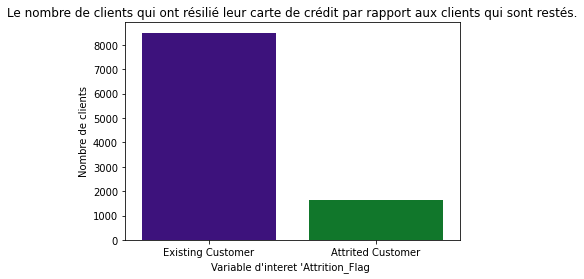

In [73]:
couleurs = ['#39008E', '#008823']
sns.set_palette(sns.color_palette(couleurs))
sns.countplot(x="Attrition_Flag", data=df)
plt.title("Le nombre de clients qui ont résilié leur carte de crédit par rapport aux clients qui sont restés.")
plt.ylabel("Nombre de clients")
plt.xlabel("Variable d'interet 'Attrition_Flag ")

Il existe un déséquilibre de classe, où une classe de la variable cible est nettement plus fréquente que l'autre. La classe majoritaire dans cet ensemble de données est "Existing Customer", ce qui signifie qu'il y a un grand nombre d'observations de clients existants par rapport aux clients non-existants. Ce déséquilibre de classe peut poser des défis dans certaines tâches d'apprentissage automatique, car les modèles peuvent avoir tendance à être biaisés en faveur de la classe majoritaire, ce qui peut entraîner une performance médiocre pour l'autre classe

Dans la suite, je vais chercher le nombre de valeurs manquantes pour chaque colonne, ainsi que les différentes classes pour chaque variable catégorielle.

In [4]:
missing_values = []
columns = df.columns.to_list()
for column in columns:
    null_values = df[column].isnull().sum()
    missing_values.append([column, null_values])
pd.DataFrame(missing_values, columns=["Column Name", "Nombre des valeurs manquantes"]).set_index("Column Name").rename_axis(None)

,Nombre des valeurs manquantes
CLIENTNUM,0
Attrition_Flag,0
Customer_Age,0
Gender,0
Dependent_count,0
Education_Level,0
Marital_Status,0
Income_Category,0
Card_Category,0
Months_on_book,0


In [4]:
# Print the categories for each categorical attribute
pd.set_option('display.max_colwidth', 0)
cat = []
for col_name in df.select_dtypes(include=['object']).columns:
    categories_list = df[col_name].value_counts().index.to_list()
    cat.append([col_name, categories_list])
pd.DataFrame(cat, columns=["Column Name", "Classes"]).set_index("Column Name").rename_axis(None)

,Categories
Attrition_Flag,"[Existing Customer, Attrited Customer]"
Gender,"[F, M]"
Education_Level,"[Graduate, High School, Unknown, Uneducated, College, Post-Graduate, Doctorate]"
Marital_Status,"[Married, Single, Unknown, Divorced]"
Income_Category,"[Less than $40K, $40K - $60K, $80K - $120K, $60K - $80K, Unknown, $120K +]"
Card_Category,"[Blue, Silver, Gold, Platinum]"


In [18]:
print("Observations avec 'Uknown': {} sur {}".format((df[(df["Education_Level"] == "Unknown") | 
   (df["Marital_Status"] == "Unknown") | 
   (df["Income_Category"] == "Unknown")].shape[0]), df.shape[0]))

Observations avec 'Uknown': 3046 out of 10127


la catégorie "Uknown" est présente dans une ou plusieurs variables. Plutôt que de la supprimer, il est important de conserver cette catégorie, car elle peut contenir une quantité significative d'informations qui peuvent être utiles dans l'analyse. Cependant, lors de l'encodage de la variable catégorielle qui contient cette catégorie, il est possible d'utiliser un encodeur ordinal pour la transformer en une variable numérique. Dans cet encodeur ordinal, la catégorie "Unknown" peut être étiquetée comme 0, ce qui signifie qu'elle sera la première catégorie numérotée. Cette approche permet de conserver les informations contenues dans la catégorie "Unknown" tout en permettant une analyse numérique plus facile des données.

# Prétraitement des données

Cette étape permet de préparer les données pour l'entraînement de modèles de prédiction. Les variables catégorielles sont encodées à l'aide de l'encodage ordinal et l'encodage one-hot pour être converties en variables numériques, et les données sont ensuite divisées en ensembles de formation et de test

In [23]:
# Defining the encoding variables
ordinal_enc_variables = ["Education_Level", "Income_Category", "Card_Category"]
one_hot_enc_variables = ["Gender", "Marital_Status"]

# Defining ordinal categories
edu_lvl = ["Unknown", "Uneducated", "High School", "College", "Graduate", "Post-Graduate", "Doctorate"]
income_cat = ["Unknown", "Less than $40K", "$40K - $60K", "$80K - $120K", "$60K - $80K", "$120K +"]
card_cat = ["Blue", "Silver", "Gold", "Platinum"]

# Create a copy of the original dataframe
df_encoded = df.copy()

# Encode ordinal variables
ord_enc = OrdinalEncoder(categories=[edu_lvl, income_cat, card_cat])
df_encoded[ordinal_enc_variables] = ord_enc.fit_transform(df_encoded[ordinal_enc_variables])

# Encode one-hot variables
one_hot_enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
one_hot_enc_df = pd.DataFrame(one_hot_enc.fit_transform(df_encoded[one_hot_enc_variables]))
one_hot_enc_df.columns = one_hot_enc.get_feature_names(one_hot_enc_variables)
df_encoded = pd.concat([df_encoded.drop(one_hot_enc_variables, axis=1), one_hot_enc_df], axis=1)

# Split the data into train and test sets
from sklearn.model_selection import train_test_split

X = df_encoded.drop(["Attrition_Flag","CLIENTNUM"], axis=1)
y = df_encoded["Attrition_Flag"]
y.replace(to_replace=["Existing Customer", "Attrited Customer"], value=[0, 1], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Établissement d'un modèle de base

Dans la suite je vise établir **un modèle de base** en utilisant différents modèles d'apprentissage automatique, notamment les arbres de decision, le forêts aléatoire et la régression logistique, et des techniques de rééchantillonnage. Les modèles testés sont la régression logistique, l'arbre de décision et la forêt aléatoire. Les techniques de **rééchantillonnage**  testées comprennent SMOTE, Random Under Sampling, SMOTENC, SMOTE with Tomek Links et Random Over Sampling.

> Le code suit les étapes suivantes pour établir le modèle de base :

* Divise les données en ensemble d'entraînement et ensemble de test.
* Initialise les modèles et les techniques de rééchantillonnage à tester.
* Itère sur chaque modèle et chaque technique de rééchantillonnage.
* Rééchantillonne les données d'entraînement en utilisant la technique de rééchantillonnage sélectionnée.
* Applique une sélection de fonctionnalités en utilisant RFECV (Recursive Feature Elimination with Cross-Validation).
* Ajuste le modèle sélectionné sur les fonctionnalités sélectionnées en utilisant un pipeline d'imbrication qui normalise les données et applique le modèle.
* Évalue les performances du modèle ajusté sur l'ensemble de test en calculant la précision, le rappel, le score F1 et l'accuracy.

Après avoir établi le modèle de base, les résultats seront enregistrés dans une base de données sous forme de tableau pour être comparés et sélectionner le modèle avec les meilleures performances.

Une fois le modèle sélectionné, une étape de **réglage** de modèle sera effectuée pour améliorer les performances du modèle. **Les hyperparamètres** seront ajustés en utilisant **une recherche sur grille** pour trouver les valeurs optimales qui maximisent les performances du modèle. Ensuite, le modèle ajusté sera évalué sur l'ensemble de test pour s'assurer qu'il **généralise** bien aux nouvelles données.

In [30]:
X_train.columns

Index(['Customer_Age', 'Dependent_count', 'Education_Level', 'Income_Category',
       'Card_Category', 'Months_on_book', 'Total_Relationship_Count',
       'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit',
       'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1',
       'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
       'Avg_Utilization_Ratio', 'Gender_F', 'Gender_M',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Unknown'],
      dtype='object')

In [33]:
%%capture
# Define the models to be tested
models = {'Logistic Regression': LogisticRegression(),
          'Decision Tree': DecisionTreeClassifier(),
          'Random Forest': RandomForestClassifier()}

# Define the resampling techniques to be tested
resamplers = {'SMOTE': SMOTE(),
              'Random Under Sampling': RandomUnderSampler(),
              'SMOTENC': SMOTENC(categorical_features=[1, 2, 3, 4, 5, 6, 7, 8, 17 ,18 ,19 ,20, 21], random_state=42),
              'SMOTE with Tomek Links': SMOTETomek(),
              'Random Over Sampling': RandomOverSampler()}

results = []
# Iterate over each model
for model_name, model in models.items():
    # Iterate over each resampling technique
    for resampler_name, resampler in resamplers.items():
        # Resample the training data
        X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)
        
        # Apply feature selection with RFECV
        selector = RFECV(model, step=1, min_features_to_select=5, cv=10)
        selector.fit(X_train_resampled, y_train_resampled)
        X_train_selected = selector.transform(X_train_resampled)
        
        # Fit the model on the selected features
        pipeline = make_imb_pipeline(StandardScaler(), model)
        pipeline.fit(X_train_selected, y_train_resampled)
        
        # Evaluate the model on the test set
        X_test_selected = selector.transform(X_test)
        y_pred = pipeline.predict(X_test_selected)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        
        # Append the results to the list
        results.append({'Model': model_name,
                        'Resampling Technique': resampler_name,
                        'Accuracy': acc,
                        'F1 Score': f1,
                        'Precision': precision,
                        'Recall': recall})

# Convert the results to a dataframe
results_df = pd.DataFrame(results)

In [36]:
results_df

,Model,Resampling Technique,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression,SMOTE,0.848963,0.637727,0.523995,0.814516
1,Logistic Regression,Random Under Sampling,0.845673,0.642258,0.516564,0.848790
2,Logistic Regression,SMOTENC,0.861797,0.657423,0.552055,0.812500
3,Logistic Regression,SMOTE with Tomek Links,0.846002,0.636646,0.517677,0.826613
4,Logistic Regression,Random Over Sampling,0.846660,0.643185,0.518519,0.846774
5,Decision Tree,SMOTE,0.933860,0.810913,0.760141,0.868952
6,Decision Tree,Random Under Sampling,0.896677,0.736134,0.631124,0.883065
7,Decision Tree,SMOTENC,0.924317,0.786642,0.728522,0.854839
8,Decision Tree,SMOTE with Tomek Links,0.927279,0.793651,0.739130,0.856855
9,Decision Tree,Random Over Sampling,0.935176,0.804757,0.791423,0.818548


> Le tableau ci-dessus montre les performances de différents modèles de classification utilisant différentes techniques de rééchantillonnage. Les modèles ont été évalués en termes d'exactitude (accuracy), de score F1 (F1 Score), de précision (precision) et de rappel (recall). Les meilleurs modèles sont :

* Random Forest avec SMOTENC : Ce modèle a obtenu la meilleure performance en terme détection les faux négatifs avec une exactitude de 0.957 et un rappel de 0,9.
* Random Forest avec Over Sampling : Ce modèle a obtenu la meilleure performance en terme détection les faux positifs avec une exactitude de 0.959 et une précision de 0.897.

Cependant, je ne m'arrêterai pas là dans ma recherche de la performance optimale. Je vais maintenant me concentrer sur l'optimisation des hyperparamètres pour affiner encore ces modèles. Je vais explorer différentes combinaisons d'hyperparamètres en utilisant des techniques telles que la validation croisée et la recherche aléatoire pour trouver le meilleur ensemble d'hyperparamètres.

# Optimisation des meilleurs modèles

Les hyperparamètres de Random Forest peuvent être divisés en deux catégories : les hyperparamètres liés aux arbres et les hyperparamètres liés à l'ensemble des arbres.

> Les hyperparamètres liés aux arbres comprennent notamment :

* Le nombre de variables à considérer pour chaque division de noeud (max_features).
* Le nombre minimum d'observations requis pour diviser un noeud (min_samples_split).
* Le nombre minimum d'observations requis pour être une feuille (min_samples_leaf).
* Le nombre maximum de profondeur de l'arbre (max_depth).
* Le nombre maximum de feuilles de l'arbre (max_leaf_nodes).

> Les hyperparamètres liés à l'ensemble des arbres comprennent notamment :

* Le nombre d'arbres dans l'ensemble (n_estimators).
* La méthode de bootstrap pour échantillonner les données (bootstrap).

L'optimisation des hyperparamètres de Random Forest peut être effectuée à l'aide d'une méthode de recherche sur grille. En trouvant les meilleurs hyperparamètres, on peut améliorer les performances du modèle.

## Randomized Search

### Random Forest avec RandomOverSampler 

Le randomized search (ou recherche aléatoire) est une méthode pour rechercher les meilleurs hyperparamètres d'un modèle de machine learning. Les hyperparamètres sont des paramètres que l'on doit fixer avant l'entraînement du modèle, tels que le nombre d'estimateurs dans un random forest ou la profondeur maximale d'un arbre de décision.

Plutôt que de tester toutes les combinaisons possibles d'hyperparamètres, ce qui peut être très coûteux en temps de calcul, la recherche aléatoire effectue une sélection aléatoire de combinaisons. On peut spécifier une distribution de probabilité pour chaque hyperparamètre, et la recherche aléatoire va tirer des valeurs au hasard dans ces distributions. On entraîne ensuite le modèle avec chaque combinaison d'hyperparamètres et on évalue ses performances.

La recherche aléatoire permet de trouver des combinaisons d'hyperparamètres performantes de manière plus rapide que la recherche exhaustive. Elle peut être utilisée en conjonction avec une validation croisée pour estimer les performances du modèle de manière plus robuste.

In [37]:
resampler = RandomOverSampler()
model = RandomForestClassifier()
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train) 
selector = RFECV(model, step=1, min_features_to_select=5, cv=10)
selector.fit(X_train_resampled, y_train_resampled)
X_train_selected = selector.transform(X_train_resampled)      
X_test_selected = selector.transform(X_test)


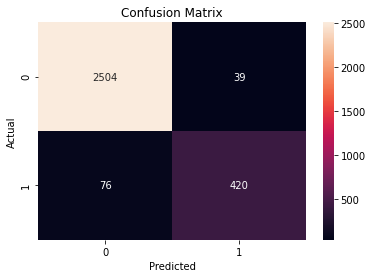

,Accuracy,Precision,Recall,F1,AUC
0,0.962159,0.915033,0.846774,0.879581,0.915719


In [40]:
# Define the model and hyperparameters to search over
rf = RandomForestClassifier()
param_dist = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['sqrt', None],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2,3,4,5,6,7],
    'min_samples_leaf': [1,2,3,4,5,6]
}

# Perform randomized search
search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=50, scoring='recall', n_jobs=-1, cv=4, random_state=1)
search.fit(X_train_selected , y_train_resampled)

# Make predictions on test set
y_pred = search.best_estimator_.predict(X_test_selected)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate metrics and create dataframe
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
metrics_df = pd.DataFrame({'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}, index=[0])
metrics_df

In [43]:
print(search.best_params_)

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}


### Random Forest avec SMOTENC

In [44]:
resampler = SMOTENC(categorical_features=[1, 2, 3, 4, 5, 6, 7, 8, 17 ,18 ,19 ,20, 21], random_state=42)
model = RandomForestClassifier()
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train) 
selector = RFECV(model, step=1, min_features_to_select=5, cv=10)
selector.fit(X_train_resampled, y_train_resampled)
X_train_selected = selector.transform(X_train_resampled)      
X_test_selected = selector.transform(X_test)

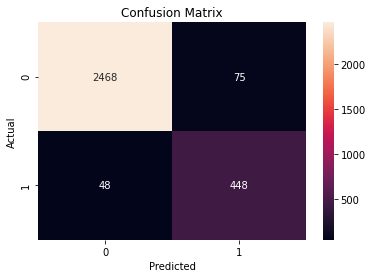

,Accuracy,Precision,Recall,F1,AUC
0,0.959526,0.856597,0.903226,0.879293,0.936867


In [49]:
# Define the model and hyperparameters to search over
rf = RandomForestClassifier()
param_dist = {
    'n_estimators': [10, 50, 100],
    'max_features': ['sqrt', None],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2,3,4,5,6,7],
    'min_samples_leaf': [1,2,3,4,5,6]
}

# Perform randomized search
search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=50, scoring='f1', n_jobs=-1, cv=5, random_state=1)
search.fit(X_train_selected , y_train_resampled)

# Make predictions on test set
y_pred = search.best_estimator_.predict(X_test_selected)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate metrics and create dataframe
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
metrics_df = pd.DataFrame({'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}, index=[0])
metrics_df

In [50]:
print(search.best_params_)

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


- Pour la technique de suréchantillonnage aléatoire (ROS) :

> Avant la recherche aléatoire des hyperparamètres :
* L'exactitude est de 0,959
* La précision est de 0,897
* Le rappel est de 0,847
* Le score F1 est de 0,871

> Après la recherche aléatoire des hyperparamètres :
* L'exactitude est de 0,962
* La précision est de 0,915
* Le rappel est de 0,847
* Le score F1 est de 0,880

- Pour la technique de suréchantillonnage SMOTENC :

> Avant la recherche aléatoire des hyperparamètres :

* L'exactitude est de 0,958
* La précision est de 0,848
* Le rappel est de 0,901
* Le score F1 est de 0,874
> Après la recherche aléatoire des hyperparamètres :
* L'exactitude est de 0,960
* La précision est de 0,857
* Le rappel est de 0,903
* Le score F1 est de 0,879

En comparant les résultats avant et après la recherche aléatoire des hyperparamètres, on peut voir que pour les deux techniques, l'exactitude et le rappel sont restés à peu près les mêmes, mais la précision et le score F1 ont légèrement augmenté après la recherche aléatoire des hyperparamètres. Cela suggère que la recherche aléatoire des hyperparamètres a aidé à optimiser les modèles et à améliorer leur performance.

# Evaluation des performances des modèles 

## Courbes ROC 

Une courbe ROC (Receiver Operating Characteristic) est une représentation graphique de la performance d'un modèle de classification binaire en fonction du seuil de classification. La courbe est créée en traçant le taux de vrais positifs (sensibilité) en fonction du taux de faux positifs (1 - spécificité) pour différentes valeurs seuils de classification.

Le taux de vrais positifs correspond au nombre de vrais positifs (classe positive correctement classée) divisé par le nombre total d'échantillons positifs. Le taux de faux positifs correspond au nombre de faux positifs (classe négative incorrectement classée comme positive) divisé par le nombre total d'échantillons négatifs.

Plus la courbe ROC est proche du coin supérieur gauche du graphique, meilleure est la performance du modèle. La zone sous la courbe ROC (AUC) est une mesure de la capacité du modèle à distinguer les échantillons positifs des échantillons négatifs. Un AUC de 0,5 correspond à une performance aléatoire, tandis qu'un AUC de 1,0 correspond à une performance parfaite.

En bref, la courbe ROC est un outil utile pour évaluer la performance d'un modèle de classification binaire et pour déterminer le meilleur seuil de classification pour optimiser la performance du modèle.


In [52]:
# Tuned RandomOverSampling Model
model1 = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=30)
ROS = RandomOverSampler()
X_train_resampled, y_train_resampled = ROS.fit_resample(X_train, y_train) 
model1.fit(X_train_resampled, y_train_resampled)
# Tuned SMOTENC model
model2 = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=20)
SMOTENC = SMOTENC(categorical_features=[1, 2, 3, 4, 5, 6, 7, 8, 17 ,18 ,19 ,20, 21])
X_train_resampled, y_train_resampled = SMOTENC.fit_resample(X_train, y_train) 
model2.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=20, max_features='sqrt')

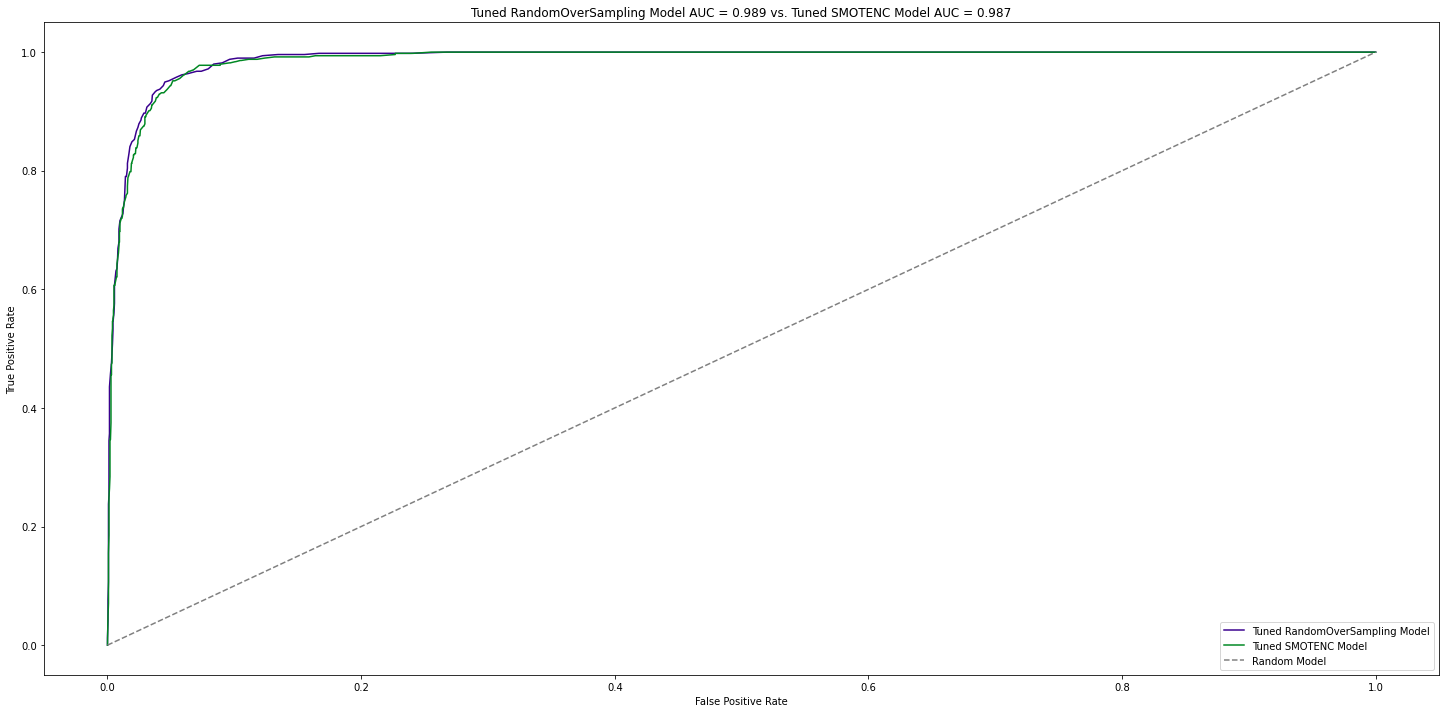

In [64]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predict using tuned RandomOverSampling model
y_pred1 = model1.predict_proba(X_test)[:,1]
fpr1, tpr1, _ = roc_curve(y_test, y_pred1)

# Predict using tuned SMOTENC model
y_pred2 = model2.predict_proba(X_test)[:,1]
fpr2, tpr2, _ = roc_curve(y_test, y_pred2)

# Calculate AUC scores for both models
auc1 = roc_auc_score(y_test, y_pred1)
auc2 = roc_auc_score(y_test, y_pred2)

# Plot ROC curves for both models
plt.figure(figsize=(25, 12))
plt.plot(fpr1, tpr1, label='Tuned RandomOverSampling Model')
plt.plot(fpr2, tpr2, label='Tuned SMOTENC Model')

# Add diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Model')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(f'Tuned RandomOverSampling Model AUC = {auc1:.3f} vs. Tuned SMOTENC Model AUC = {auc2:.3f}')
plt.show()

Les deux modèles de classification, RandomOverSampling et SMOTENC, ont été évalués en utilisant la courbe ROC. Les résultats ont montré que les deux modèles ont des performances similaires avec une AUC (Area Under the Curve) proche de 1.0, ce qui indique une très bonne capacité à discriminer entre les classes positives et négatives. Cependant, le modèle RandomOverSampling a obtenu une AUC légèrement supérieure de 0.989, comparé à celle de 0.987 du modèle SMOTENC. Ces résultats suggèrent que les deux modèles sont performants pour classer les données déséquilibrées de l'ensemble de données de churn bancaire, mais le modèle RandomOverSampling est légèrement meilleur que le modèle SMOTENC.

## Courbes Precision Recall 

La courbe Precision-Recall est un autre outil d'évaluation pour les modèles de classification binaire. Elle est utilisée pour évaluer les performances du modèle lorsque la distribution des classes est déséquilibrée.

La précision mesure la proportion d'observations positives prédites correctement parmi toutes les observations positives prédites. Le rappel (recall) mesure la proportion d'observations positives prédites correctement parmi toutes les observations positives réelles.

La courbe Precision-Recall représente graphiquement la relation entre la précision et le rappel en variant le seuil de décision du modèle. À chaque seuil, on calcule la précision et le rappel et on relie ces points entre eux pour obtenir la courbe.

Un modèle idéal aura une précision de 1 et un rappel de 1, ce qui donnera un point en haut à droite du graphique. Un modèle aléatoire aura une courbe qui suit une ligne droite horizontale à la valeur de la fréquence des observations positives dans les données.

En général, plus la courbe Precision-Recall est proche du coin supérieur droit, meilleure est la performance du modèle.

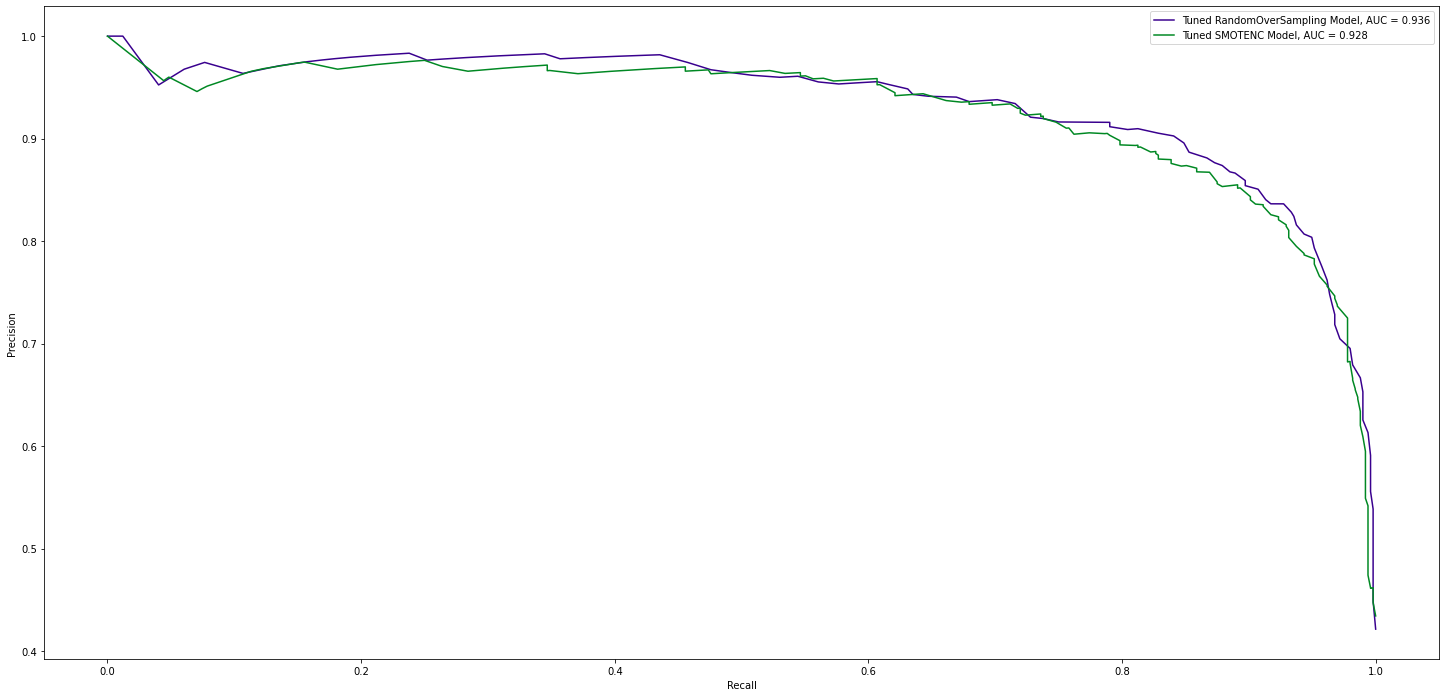

In [78]:
# Predict using tuned RandomOverSampling model
y_pred1 = model1.predict_proba(X_test)[:,1]
precision1, recall1, _ = precision_recall_curve(y_test, y_pred1)
auc1 = auc(recall1, precision1)

# Predict using tuned SMOTENC model
y_pred2 = model2.predict_proba(X_test)[:,1]
precision2, recall2, _ = precision_recall_curve(y_test, y_pred2)
auc2 = auc(recall2, precision2)

# Plot Precision-Recall curves for both models
plt.figure(figsize=(25, 12))
plt.plot(recall1, precision1, label='Tuned RandomOverSampling Model, AUC = {:.3f}'.format(auc1))
plt.plot(recall2, precision2, label='Tuned SMOTENC Model, AUC = {:.3f}'.format(auc2))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


Les courbes de Precision Recall montrent que les deux modèles ont des performances similaires, mais le modèle de RandomOverSampling est légèrement meilleur que le modèle de SMOTENC. Cela est confirmé par la surface sous la courbe (AUC), qui est de 0,936 pour le modèle de RandomOverSampling et de 0,928 pour le modèle de SMOTENC. De plus, en comparant les deux courbes, on peut voir que la courbe SMOTENC est presque toujours en dessous de la courbe ROS, ce qui indique que le modèle ROS est plus précis dans la détection des vrais positifs que le modèle SMOTENC. 

## Calibration des deux modèles 

La calibration est la mesure de la capacité d'un modèle de classification à prédire avec précision la probabilité d'une classe spécifique. La calibration est importante car elle permet de s'assurer que la probabilité prédite correspond à la probabilité réelle. Un modèle qui est mal calibré peut donner des prédictions erronées même s'il est très précis.

Le score de Brier est une mesure de la qualité de la calibration d'un modèle de classification. Il mesure la différence entre les probabilités prédites par le modèle et les probabilités réelles. Le score de Brier varie de 0 à 1, où une valeur de 0 correspond à une calibration parfaite et une valeur de 1 correspond à une mauvaise calibration.

Brier Score for Tuned RandomOverSampling Model: 0.03655133267522211
Brier Score for Tuned SMOTENC Model: 0.039657199346429334


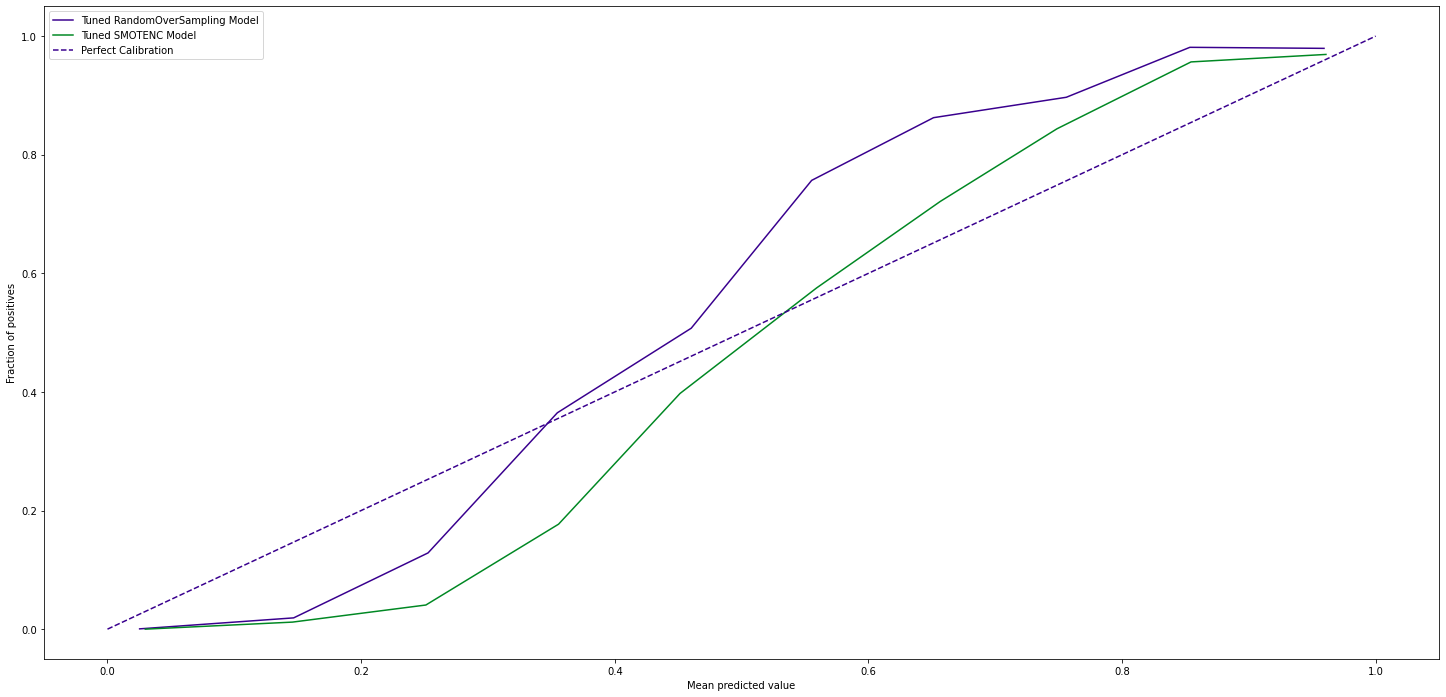

In [77]:
# Generate calibration plots and scores for the Tuned RandomOverSampling Model
prob1 = model1.predict_proba(X_test)[:, 1]
fraction_of_positives1, mean_predicted_value1 = calibration_curve(y_test, prob1, n_bins=10, strategy='uniform')
brier_score1 = brier_score_loss(y_test, prob1, pos_label=1)

# Generate calibration plots and scores for the Tuned SMOTENC Model
prob2 = model2.predict_proba(X_test)[:, 1]
fraction_of_positives2, mean_predicted_value2 = calibration_curve(y_test, prob2, n_bins=10, strategy='uniform')
brier_score2 = brier_score_loss(y_test, prob2, pos_label=1)

# Plot calibration curves for both models
plt.figure(figsize=(25, 12))
plt.plot(mean_predicted_value1, fraction_of_positives1, label='Tuned RandomOverSampling Model')
plt.plot(mean_predicted_value2, fraction_of_positives2, label='Tuned SMOTENC Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.legend()

# Print calibration scores for both models
print('Brier Score for Tuned RandomOverSampling Model:', brier_score1)
print('Brier Score for Tuned SMOTENC Model:', brier_score2)


Les deux modèles ont obtenu des scores de Brier satisfaisants, avec 0.036 pour le modèle de RandomOverSampling et 0.039 pour le modèle de SMOTENC, ce qui indique qu'ils sont bien calibrés. Cependant, l'examen de la courbe de calibration montre que le modèle de RandomOverSampling est légèrement sous-calibré pour les valeurs de probabilité les plus basses, avant de devenir légèrement sur-calibré pour les valeurs plus élevées, tandis que le modèle de SMOTENC est légèrement sur-calibré pour les valeurs de probabilité supérieures à environ 0.5.

# Conlusion 

En conclusion, les modèles entraînés avec la recherche aléatoire et le modèle Random Forest ont donné d'excellents résultats dans la prédiction de la résiliation des clients bancaires. Les deux modèles ont montré de bonnes performances en termes de précision, de rappel, d'AUC-ROC et de score de Brier, indiquant qu'ils sont bien calibrés et ont une capacité de discrimination élevée. 